In [1]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# , Lewis Wolpert famously wrote that “gastrulation … is truly the most important moment of your life.”


In [7]:
positions = np.load("../amnioserosa_elongation/toshow.npy")

xx, zz, yy = positions[:,:,0], positions[:,:,1], positions[:,:,2]

# reassemble the 3D points
positions = np.concatenate([xx[:, :, None], yy[:, :, None], zz[:, :, None]], axis=2)


props = np.load("../amnioserosa_elongation/toshow_props.npy")

A cell’s strain is calculated in a five step process. First, at each time instant a large number of subgraphs are sampled from 
 (Fig. 2 A). Second, the incremental deformation gradient of each subgraph is computed (Fig. 2 B). Third, a cell’s incremental deformation gradient is computed as the average of the incremental deformation gradients of the subgraphs to which it belongs (Fig. 2 C). Fourth, the cell’s deformation gradient at each time point is updated from the incremental deformation gradient (Fig. 2 D). Fifth, the cell’s strain is computed from its deformation gradient using Eq. 2.


In [8]:
k = 30
subgraph_k = 10
N_subgraphs = 5

def cutoff_and_knn(points, cutoff : float):
    """
    Find all up to k points are are witin a certain distance of each other
    """
    tree = KDTree(points)
    distances, indices = tree.query(points, k=k)
    
    indices[distances > cutoff] = -1

    return indices

def find_knn_nbs(positions : np.ndarray) -> np.ndarray:
    """
    Find the k nearest neighbors of each point
    """
    return cutoff_and_knn(positions, 10.)

def find_random_subgraphs(positions : np.ndarray, nbs : np.ndarray) -> np.ndarray:
    knn_nbs =  find_knn_nbs(positions)


    subgraphs = -np.ones((positions.shape[0], N_subgraphs, subgraph_k), dtype=np.int32)

    for i in range(positions.shape[0]):
        nbs = knn_nbs[i]

        nbs_add = np.append(nbs[nbs != -1], i)

        for n in range(N_subgraphs):
            sub = np.random.choice(nbs_add, subgraph_k, replace=False)
            subgraphs[i, n] = sub

    return subgraphs

def find_incremental_deformation_gradient_for_subgraphs(positions : np.ndarray, positions_1 : np.ndarray, subgraph : np.ndarray) -> np.ndarray:
    # position shape [N_cells, 3]
    # subgraph shape [N_subgraphs, subgraph_k]

    # Find the deformation gradient for a subgraph
    subgraph = subgraph.flatten()
    
    subgraph = np.unique(subgraph)

    # find the relative position vectors between every pair of cells
    relative_position_vectors = positions[subgraph] - positions[subgraph][:, np.newaxis]

    relative_position_vectors_1 = positions_1[subgraph] - positions_1[subgraph][:, np.newaxis]

    # remove the duplicates
    relative_position_vectors = relative_position_vectors[np.triu_indices(subgraph.shape[0], k=1)]
    relative_position_vectors_1 = relative_position_vectors_1[np.triu_indices(subgraph.shape[0], k=1)]

    Lam = relative_position_vectors.T # shape [combinations in subgraph, 3]

    Lam1 = relative_position_vectors_1.T # TODO: optimize, this is already calculated in the previous step
    

    FD = Lam1 @ Lam.T @ np.linalg.inv(Lam @ Lam.T)

    # FD shape [combinations in subgraph, combinations in subgraph]                                            [N_cells*subgraph_k, 3, 3]
    return FD


def find_incremental_deformation_gradient(positions : np.ndarray, positions_1 : np.ndarray, nbs : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Find the incremental deformation gradient for each cell
    """
    subgraphs = find_random_subgraphs(positions, nbs)


    FDs = np.zeros((positions.shape[0] * N_subgraphs, 3, 3))
    # FDs = np.zeros((positions.shape[0] , 3, 3))


    # TODO: Vectorize this
    for i in range(positions.shape[0]):
        for j in range(N_subgraphs):
            fd = find_incremental_deformation_gradient_for_subgraphs(positions, positions_1, subgraphs[i,j])
            FDs[i*N_subgraphs + j] = fd


    return  FDs, subgraphs

def find_cell_incremental_deformation_gradient(positions : np.ndarray, positions_1 :np.ndarray, nbs : np.ndarray) -> np.ndarray:
    FDs, subgraphs = find_incremental_deformation_gradient(positions, positions_1, nbs)

    # FDs shape       [N_cells * N_subgraphs,   3,    3]
    # subgraphs shape [N_cells, N_subgraphs, subgraph_k]
    subgraphs = subgraphs.reshape(-1, subgraph_k)


    all_FD = np.zeros((positions.shape[0], 3, 3))

    for i in range(positions.shape[0]):
        where = np.where(subgraphs == i)[0]

        FD = FDs[where].mean(axis=0)

        all_FD[i] = FD
        # FD shape [3, 3]

    return all_FD
    

 

def compute_cell_deformation_gradient(all_positions : np.ndarray) -> np.ndarray:
    
    n_timesteps = all_positions.shape[0]
    n_cells = all_positions.shape[1]

    F = np.zeros((n_timesteps - 1, n_cells, 3, 3))

    # fill with eye
    F[0, :] = np.eye(3)

    F_minus_1 = [np.eye(3) for _ in range(n_cells)]

    for i in range(all_positions.shape[0] - 1):
        print(i/(all_positions.shape[0] - 1)*100., end="\r")
        positions = all_positions[i]
        positions_1 = all_positions[i + 1]

        nbs = find_knn_nbs(positions)

        FD = find_cell_incremental_deformation_gradient(positions, positions_1, nbs)

        F[i] = np.einsum('rmn,rnd->rmd', FD, F_minus_1)

        F_minus_1 = F[i]

    
    return F


def compute_cell_strain(F : np.ndarray) -> np.ndarray:
    
    E = np.zeros_like(F)

    for i in range(F.shape[0]):
        f = F[i].T # shape [3, 3, N_cells]
        ft = np.transpose(f, [1,0,2]) # shape [3, 3, N_cells]

        I = np.eye(3) # shape [3, 3]
        res =  0.5 * (np.einsum('mnr,ndr->mdr', ft, f) - I[:,:,None]) # shape [3, 3, N_cells]

        E[i] = res.T

    return E



F = compute_cell_deformation_gradient(positions)

E = compute_cell_strain(F)


In [79]:
F.shape

(14, 5000, 3, 3)

In [28]:
props.shape

(1, 5000)

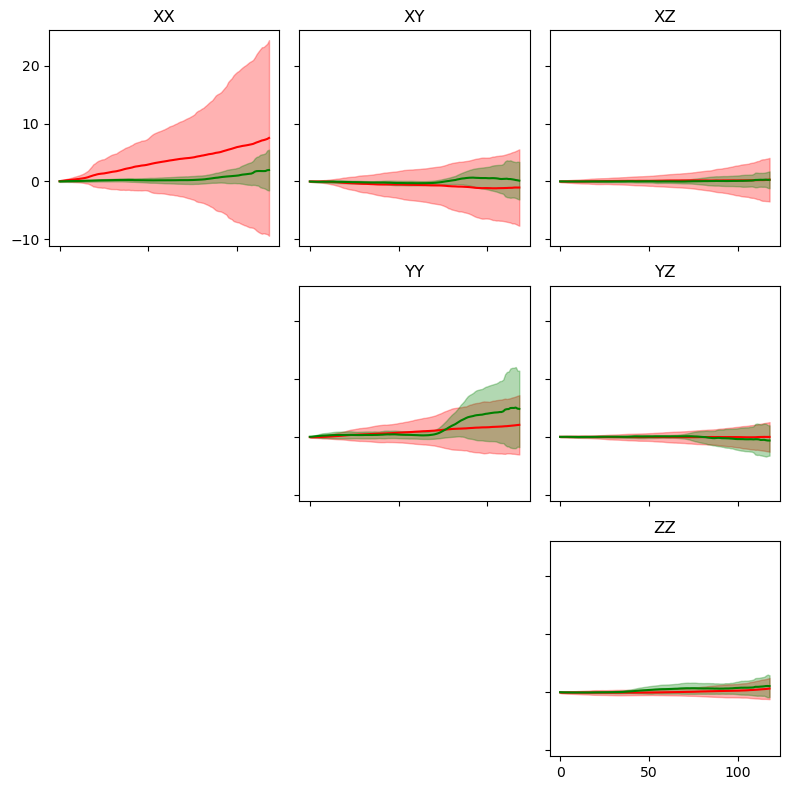

In [11]:


fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True, tight_layout=True)


cols = ['r', 'g', ]

pro = [1, 4]
for x in range(3):
    for y in range(x, 3):
        for i in range(2):
            axs[x,y].plot(E[:, props[0] == pro[i]].mean(axis = 1)[:,x,y], c = cols[i],)
            axs[x,y].fill_between(np.arange(E.shape[0]), E[:, props[0] == pro[i]].mean(axis = 1)[:,x,y] - E[:, props[0] == pro[i]].std(axis = 1)[:,x,y], E[:, props[0] == pro[i]].mean(axis = 1)[:,x,y] + E[:, props[0] == pro[i]].std(axis = 1)[:,x,y], alpha=0.3, color=cols[i])
            
        axs[x,y].set_title(f"{['X', 'Y', 'Z',][x]}{['X', 'Y', 'Z',][y]}")  

# remove the unused axes
for x in range(3):
    for y in range(3):
        if x > y:
            axs[x,y].axis('off')

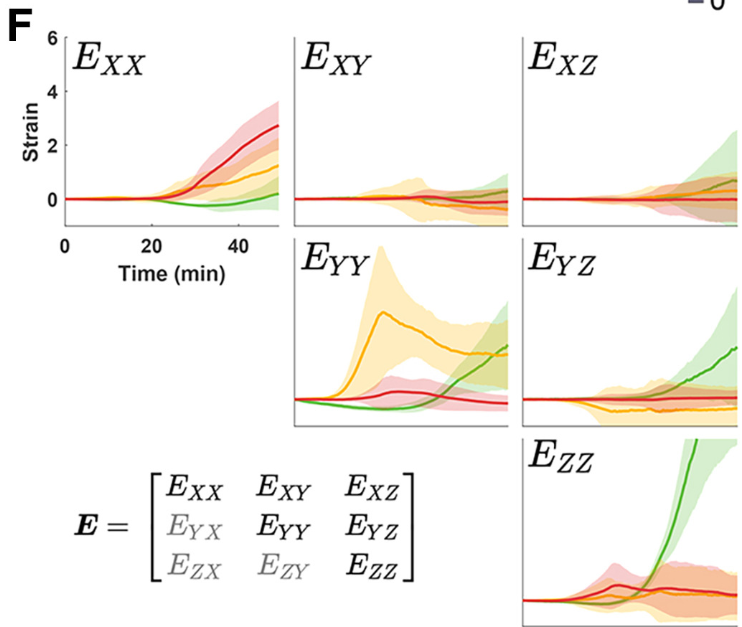

In [36]:
# do k means clustering on the strain tensor

from sklearn.cluster import KMeans

reshaped =np.moveaxis(E, 0, 1)
print(reshaped.shape)

reshaped = reshaped.reshape(reshaped.shape[0], -1)

kmeans = KMeans(n_clusters=4, random_state=10,).fit(reshaped)

print(kmeans.labels_.shape)

(5000, 119, 3, 3)


c:\Users\jakob\miniconda3\envs\reworked\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(5000,)


array([0, 0, 0, ..., 1, 1, 1])

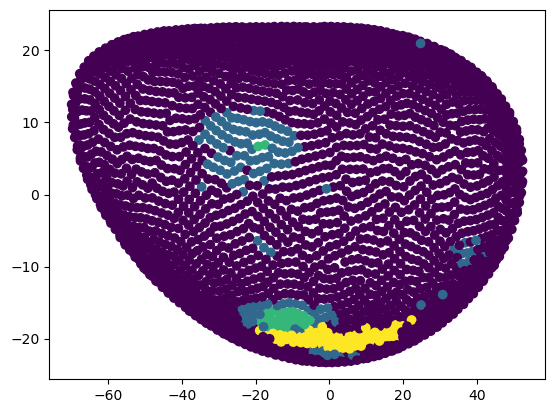

In [37]:
# e_per_cell = E.mean(axis=0)
zz = positions[0,:, 2] <0
plt.scatter(positions[0,:, 0][zz], positions[0,:, 1][zz], c=kmeans.labels_[zz])

In [17]:


def test():
    test3()


def test3():
    print("test3")

test()

test3
